## Point Location

This Jupyter Notebook will give an extensive explanation of the *point location query problem*. A point location query looks as follows:

*Given a planar subdivision and a query point q specified by its coordinates, find the face of the subdivision containing q.* 

The goal of the point location query problem is to preprocess the planar subdivision in such a way that for every query point q, the face of the subdivision containing q can be given efficiently.

In this Jupyter Notebook we will explain two separate algorithms for solving the point location problem. 

***
**Planar Subdivision:** A planar subdivision consists of vertices, edges and faces. An edge is considered to be open. More specifically, an edge is simply a straight line segment in which it’s both endpoints are not included. These endpoints are called vertices. A face is a maximal connected subset of edges.
The subdivision of a planar subdivision is defined as the sum of the number of vertices, edges and faces it consists of.

To represent this planar subdivision into practice we will make use of a so-called doubly-connected edge list.

<font color='red'>ToDo: DCEL Explanation</font>

<font color='red'>ToDo: Something about general position assumption and possibly other assumptions</font>

To create such a DCEL we have to input some points and segments. Our created DCEL implementation will walk through the following steps to create the DCEL:
1.	For every point we create a vertex
2.	For every segment, we create 2 half-edges and set up twin pointers between them. 
3.	For every half-edge we set up the next and previous pointers. We do this by looping over all vertices and for every vertex we get all half-edges leaving this vertex sorted in clock-wise order. We then have for every pair of neighboring half-edges, let’s say h1 and h2 that the next half-edge for the twin of h1 is h2 (h1.twin.next = h2). Logically we then also have that the previous half-edge of h2 is the twin of h1 (h2.prev = h1.twin).

<font color='red'>ToDo: Bounding box</font>

4.	Discover all faces and store them. To do this, we visit all half-edges that have not been assigned an incident face yet. Once we have such an half-edge h, we continue following the next pointers until we arrive again at our starting half-edge h. All these half-edges together form a face, and their incident-face properties are set to this face.

To be able to quickly find the half-Edge object corresponding to the origin and destination of an half-edge we have created a 2D-mapping. This mapping is simply a 2-dimensonal dictionary, that given two vertices as input, returns the half-edge object having the first vertex as origin and the second vertex as destination. Using this mapping we can find the hedge object belonging to an origin and destination in constant time. But more importantly we can use it to find, given an origin, all hedges having this vertex as origin in constant time. Similarly we can find all hedges having this point as destination.

An example planar subdivision is given below.
***

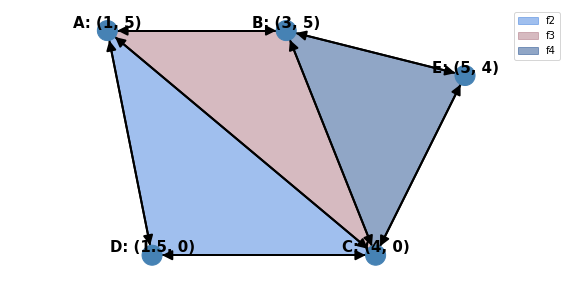

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]  # Set default size of matplot plots in jupyter notebook

import backend.dcel as dcel
import backend.slab_decomposition as sd
import backend.visualization as vs
points = [(1, 5), (3, 5), (4, 0), (1.5, 0), (5, 4)]

segments = [
    [(1, 5), (3, 5)],
    [(3, 5), (4, 0)],
    [(4, 0), (1.5, 0)],
    [(1.5, 0), (1, 5)],
    [(1, 5), (4, 0)],
    [(3, 5), (5, 4)],
    [(4, 0), (5, 4)],
]

myDCEL = dcel.Dcel()
myDCEL.build_dcel(points, segments)

myDCEL.show_dcel()

In our visual representation of the DCEL, vertices are visualized as blue dots and are labeled with a letter followed by their respective x- and y-coordinate. An half-edge and it’s corresponding twin is presented as a single bi-directional edge and a face is visualized by it’s color with a legend given in the top right.

In the end we want to build a data structure from such a DCEL, that can quickly find the face containing a query point q. For example query point (1.25, 4) belongs to face 'f2'.

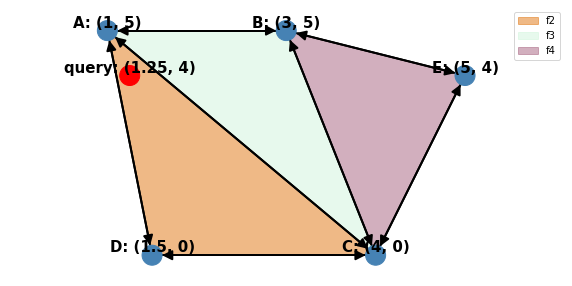

In [12]:
class QueryPoint:
    def __init__(self, x, y):
        self.x = x
        self.y = y

q = QueryPoint(1.25, 4)
myDCEL.show_dcel(q)

### Algorithm 1: Slab decomposition

The first algorithm we’ll discuss is what we refer to as the ‘slab decomposition’ algorithm. With this algorithm we create a simple, convenient data structure to perform point location queries. The planar subdivision is first divided into vertical slabs by drawing vertical lines through all vertices as can be seen below.

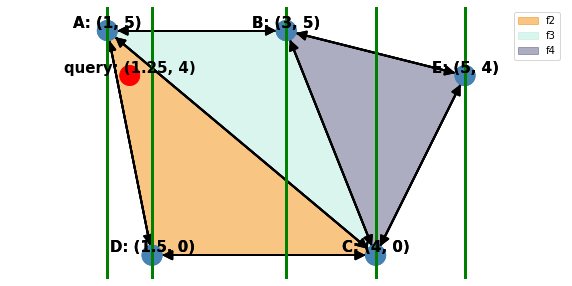

In [13]:
slab_decomposition = sd.SlabDecomposition(myDCEL)
slab_decomposition.show_slab_decomposition(q)

Because every vertex is responsible for a vertical line of a slab, we must have that within a slab, no vertices are located. Because of this no edge starts or ends within a slab, thus all edges intersecting a slab completely cross the slab. The edges are also by assumption not allowed to cross each other.
Because of these two properties we have that within a slab, edges can be ordered from top to bottom. Every region between two consecutive edges of a slab belong to a unique face of the planar subdivision. The regions below and above the lowest and highest edges within a slab, belong to the outer face. 

If we now want to find a face containing a query point q, we first need to find the slab it belongs to. And after that we want to know above and below which edges of the slab it lies. If we then find a half-edge of the face, q belongs to, we can access the ‘incident-face’ component to find the face and answer the query.

***
**But first we need to create the slabs**

A slab object is defined by three properties 1) Begin x-coordinate 2) End x-coordinate 3) The intersection edges ordered from top to bottom.

We first construct all slabs by walking through all vertices in sorted order and introducing a slab for every vertex we visit and the previously visited vertex (except the first vertex as it has no previous vertex). To then find all edges belonging to a single slab we walk through all edges and see if the edge starts left (or on boundary) of the slab and ends right (or on boundary) of the slab.

These edges are then all collected and lexicographically sorted on the y-value of the intersection of the edge with the left and right boundary of the slab. First they are sorted on the left intersection y-value and if two edges have the same value here, we compare the right intersection y-value. If both the left intersection y-value and the right intersection y-value would be exactly the same the edges would have overlap which is not allowed by the general assumption. Therefore we must have that a valid ordering among the edges can be found.
***

**Finding the slab containing q**

To find the slab corresponding to query point q we use a binary search tree on the begin x-coordinate of the slabs. We need to guarantee the binary search tree is balanced to ensure O(log n) query time for finding the slab of query point q. To guarantee this, we first sort the slabs on their begin x-coordinate and from there we make the middle slab the root node and recurse on the slabs to the left of the middle slab for the left child, and similarly recurse on the slabs to the right of the middle slab for the right child.

Slabs to the left of a node of the binary search tree, have a begin x-coordinate smaller than that of the node and slabs to the right have a begin x-coordinate greater than that of the node. By taking the middle slab to be this node, we have that approximately half of the remaining slabs lie to the left of this node and approximately half of the remaining slabs lie to the right of this node, ensuring the resulting binary search tree is balanced. 

Now that we have constructed this binary search tree we find the corresponding slab by simply traversing it from top to bottom, starting from the root. At each node we first check if q is contained within this slab. If this is the case we have found the corresponding slab. If not we continue at the left child if q.x is smaller or equal than the begin x-coordinate of the current node and otherwise we continue at the right child.

In this python code you will see we keep track of a list called ‘visited’ instead of returning solely the slab once we have found it. The reason for this is that we want to track the search path to be able to visualize it. Given the set of all visited slabs on the search path, we can quickly find the slab containing q by taking the last slab added to that list.

For the q (1.25, 4) of the example we will walk through the red marked path of the binary search tree shown below.


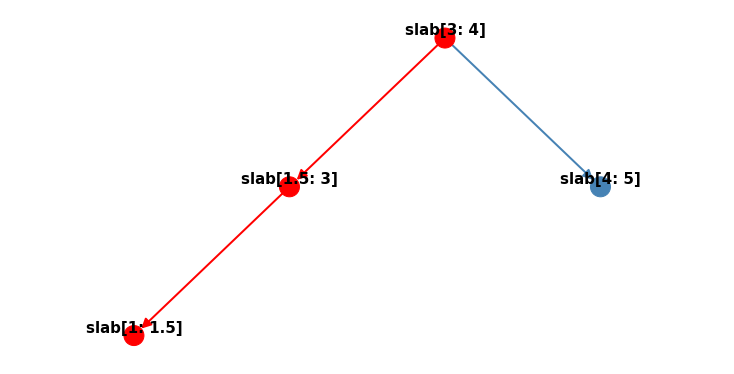

In [14]:
result = slab_decomposition.solve_for_point(q, True)  # True = show bst
slab = result[0]
visited_edges = result[1]
face = result[2]

In the end we find the slab object containing q (1.25, 4). This is the slab object that starts at x = 1 (open) and ends at x = 1.5 (closed). The assumption that the left boundary of a slab is open and the right boundary of a slab is closed is needed to ensure that a query point lying on such a boundary is not contained in two slabs instead of one.

**Finding the face containing q**

Now that we have found the slab. The next step is to find the half edge of the face containing q. If we find this half-edge we can simply access the ‘incident_face’ component which will be the face containing q.

To do this we use a binary search tree on the edges going through the slab, ordered from bottom to top. Similarly as with the binary search tree for slabs, we make the middle edge the root node and recurse on the edges to the left of the middle edge for the left child, and recurse on the edges to the right of the middle edge for the right child. This way we ensure a balanced binary search tree.

Now that we have constructed this binary search tree we find the corresponding edge by simply traversing it starting at the root. For each node we calculate what the y-value of the edge of the node would be at the x-coordinate of the query point. With this we know if the query point lies above or below an edge.
For example for the edge going from A: (1, 5) to C: (4, 0) the y-value at q.x = 1.25, would be 4.58333. Since q.y = 4, we know that our query point lies below this edge, so we recurse to the left child.

We continue walking this path until we end up in a leaf node. This leaf node must be an edge of the face that contains q. But as we know this edge consists of two half edges, where both half-edges have a different incident face. Therefore we check for the last time if the query point lies above or below the edge. If it lies below, we need the ‘incident_face’ property of the half-edge pointing to the left. If it lies above, we need the ‘incident_face’ property of the half-edge pointing to the right.

We return this face, which is our ultimate answer of the query. Again, in the python code, we also include a list called ‘visited’. This is so we are able to visualize the path taken in the binary search tree.


<font color='red'>ToDo: Explaining searching for edges within slab with binary search tree y-order image</font>

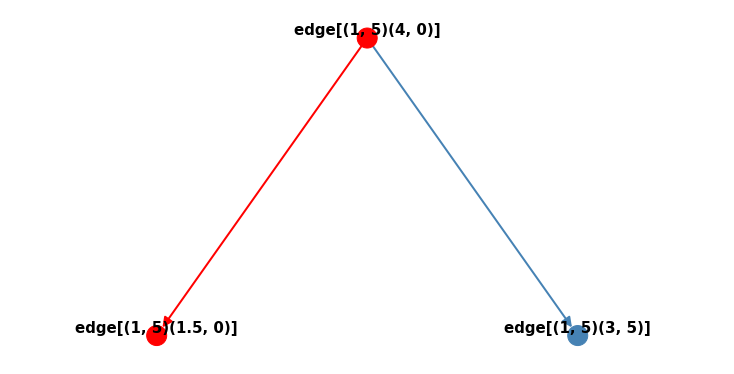

The face containg q is: f2


In [15]:
slab.show_edges_bst(visited_edges)  # Show binary search tree on y-order with marking visited nodes

print("The face containg q is: " + str(face.name))  # Print face

So in the end we find that face ‘f2’ is the face that contains our query point q (1.25, 4). Looking at the images of the planar subdivision with our query point, we see that this is indeed correct.

<font color='red'>ToDo: Running time query</font>
    <font color='red'>ToDo: Expected storage</font>

<font color='red'>ToDo: Complex Algorithm</font>